# Treinamento de Redes Neurais

A rede que construímos na parte anterior não é tão inteligente, não sabe nada sobre os nossos dígitos manuscritos. Redes neurais com ativações não lineares funcionam como aproximadores de funções universais. Existe alguma função que mapeia sua entrada para a saída. Por exemplo, imagens de dígitos manuscritos para classificar probabilidades. O poder das redes neurais é que podemos treiná-las para aproximar essa função e, basicamente, qualquer função com dados e tempo de computação suficientes.

<img src="assets/function_approx.png" largura=500px>

A princípio a rede é ingênua, não conhece a função que mapeia as entradas para as saídas. Treinamos a rede mostrando exemplos de dados reais e, em seguida, ajustando os parâmetros da rede de forma que se aproxime desta função.

Para encontrar esses parâmetros, precisamos saber quão mal a rede está prevendo os resultados reais. Para isso calculamos uma **função de perda** (também chamada de custo), uma medida do nosso erro de previsão. Por exemplo, a perda quadrática média é frequentemente usada em problemas de regressão e classificação binária

$$
\large \ell = \frac{1}{2n}\sum_i^n{\left(y_i - \hat{y}_i\right)^2}
$$

onde $n$ é o número de exemplos de treinamento, $y_i$ são os rótulos verdadeiros e $\hat{y}_i$ são os rótulos previstos.

Ao minimizar esta perda em relação aos parâmetros da rede, podemos encontrar configurações onde a perda é mínima e a rede é capaz de prever os rótulos corretos com alta precisão. Encontramos esse mínimo usando um processo chamado **gradiente descendente**. O gradiente é a inclinação da função de perda e aponta na direção da mudança mais rápida. Para chegar ao mínimo no menor tempo, queremos então seguir o gradiente (para baixo). Você pode pensar nisso como descer uma montanha seguindo a encosta mais íngreme até a base.

<img src='assets/gradient_descent.png' largura=350px>

## Backpropagation

Para redes de camada única, a descida gradiente é simples de implementar. No entanto, é mais complicado para redes neurais multicamadas mais profundas como a que construímos. Complicado o suficiente, demorou cerca de 30 anos até que os pesquisadores descobrissem como treinar redes multicamadas.

O treinamento de redes multicamadas é feito por meio de **backpropagation**, que na verdade é apenas uma aplicação da regra da cadeia do cálculo. É mais fácil de entender se convertermos uma rede de duas camadas em uma representação gráfica.

<img src='assets/backprop_diagram.png' largura=550px>

Na passagem direta pela rede, nossos dados e operações vão de baixo para cima aqui. Passamos a entrada $x$ por uma transformação linear $L_1$ com pesos $W_1$ e vieses $b_1$. A saída então passa pela operação sigmóide $S$ e outra transformação linear $L_2$. Finalmente calculamos a perda $\ell$. Usamos a perda como uma medida de quão ruins são as previsões da rede. O objetivo então é ajustar os pesos e vieses para minimizar a perda.

Para treinar os pesos com gradiente descendente, propagamos o gradiente da perda para trás através da rede. Cada operação possui algum gradiente entre as entradas e saídas. À medida que enviamos os gradientes para trás, multiplicamos o gradiente de entrada pelo gradiente da operação. Matematicamente, isso é apenas calcular o gradiente da perda em relação aos pesos usando a regra da cadeia.

$$
\large \frac{\partial \ell}{\partial W_1} = \frac{\partial L_1}{\partial W_1} \frac{\partial S}{\partial L_1} \frac{\partial L_2}{\partial S} \frac{\partial \ell}{\partial L_2}
$$

**Observação:** estou encobrindo alguns detalhes aqui que exigem algum conhecimento de cálculo vetorial, mas eles não são necessários para entender o que está acontecendo.

Atualizamos nossos pesos usando este gradiente com alguma taxa de aprendizado $\alpha$.

$$
\large W^\prime_1 = W_1 - \alpha \frac{\partial \ell}{\partial W_1}
$$

A taxa de aprendizagem $\alpha$ é definida de forma que as etapas de atualização do peso sejam pequenas o suficiente para que o método iterativo se estabeleça no mínimo.

## Losses in PyTorch

Vamos começar vendo como calculamos a perda com PyTorch. Através do módulo `nn`, PyTorch fornece perdas como a perda de entropia cruzada (`nn.CrossEntropyLoss`). Normalmente você verá a perda atribuída ao `critério`. Conforme observado na última parte, com um problema de classificação como o MNIST, estamos usando a função softmax para prever probabilidades de classe. Com uma saída softmax, você deseja usar entropia cruzada como perda. Para realmente calcular a perda, primeiro você define o critério e depois passa a saída da sua rede e os rótulos corretos.

Algo realmente importante a ser observado aqui. Olhando [a documentação para `nn.CrossEntropyLoss`](https://pytorch.org/docs/stable/nn.html#torch.nn.CrossEntropyLoss),

> Este critério combina `nn.LogSoftmax()` e `nn.NLLLoss()` em uma única classe.
>
> Espera-se que a entrada contenha pontuações para cada classe.

Isso significa que precisamos passar a saída bruta de nossa rede para a perda, não a saída da função softmax. Essa saída bruta é geralmente chamada de *logits* ou *scores*. Usamos os logits porque o softmax fornece probabilidades que geralmente serão muito próximas de zero ou um, mas os números de ponto flutuante não podem representar com precisão valores próximos de zero ou um ([leia mais aqui](https://docs.python.org /3/tutorial/ponto flutuante.html)). Geralmente é melhor evitar fazer cálculos com probabilidades, normalmente usamos log-probabilidades.

In [18]:
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,)),
                              ])
# Download and load the training data
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

### Note
Se você ainda não viu `nn.Sequential`, por favor termine o final do caderno da Parte 2.

In [19]:
# Build a feed-forward network
model = nn.Sequential(nn.Linear(784, 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64, 10))

# Define the loss
criterion = nn.CrossEntropyLoss()

# Get our data
dataiter = iter(trainloader)

images, labels = next(dataiter)

# Flatten images
images = images.view(images.shape[0], -1)

# Forward pass, get our logits
logits = model(images)
# Calculate the loss with the logits and the labels
loss = criterion(logits, labels)

print(loss)

tensor(2.3235, grad_fn=<NllLossBackward0>)


Na minha experiência, é mais conveniente construir o modelo com uma saída log-softmax usando `nn.LogSoftmax` ou `F.log_softmax` ([documentação](https://pytorch.org/docs/stable/nn.html#torch .nn.LogSoftmax)). Então você pode obter as probabilidades reais tomando o exponencial `torch.exp(output)`. Com uma saída log-softmax, você deseja usar a perda de probabilidade de log negativa, `nn.NLLLoss` ([documentação](https://pytorch.org/docs/stable/nn.html#torch.nn.NLLLoss)) .

>**Exercício:** Construa um modelo que retorne o log-softmax como saída e calcule a perda usando o log de perda de probabilidade negativa. Observe que para `nn.LogSoftmax` e `F.log_softmax` você precisará definir o argumento da palavra-chave `dim` apropriadamente. `dim = 0` calcula softmax nas linhas, de modo que cada coluna soma 1, enquanto `dim = 1` calcula nas colunas de forma que cada linha soma 1. Pense em como você deseja que a saída seja e escolha `dim` apropriadamente .

In [20]:
# TODO: Build a feed-forward network
model = 

# TODO: Define the loss
criterion = 

### Run this to check your work
# Get our data
dataiter = iter(trainloader)

images, labels = next(dataiter)

# Flatten images
images = images.view(images.shape[0], -1)

# Forward pass, get our logits
logits = model(images)
# Calculate the loss with the logits and the labels
loss = criterion(logits, labels)

print(loss)

SyntaxError: invalid syntax (736701735.py, line 2)

In [ ]:
# Define a class for the model
class LogSoftmaxModel(nn.Module):
    def __init__(self):
        super(LogSoftmaxModel, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(784, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 10)
        )
        self.log_softmax = nn.LogSoftmax(dim=1)  # Apply log-softmax along dimension 1

    def forward(self, x):
        x = x.view(-1, 784)  # Flatten input tensor
        x = self.layers(x)
        return self.log_softmax(x)

# Create an instance of the model
model = LogSoftmaxModel()

# Define the negative log likelihood loss
criterion = nn.NLLLoss()

# Assuming you have your data loaded in 'images' and 'labels'
# Forward pass
log_ps = model(images)

# Calculate the loss
loss = criterion(log_ps, labels)

print(loss)


tensor(2.3005, grad_fn=<NllLossBackward0>)


## Autograduação

Agora que sabemos como calcular uma perda, como podemos utilizá-la para realizar a retropropagação? O Torch fornece um módulo, `autograd`, para calcular automaticamente os gradientes dos tensores. Podemos usá-lo para calcular os gradientes de todos os nossos parâmetros em relação à perda. O Autograd funciona monitorando as operações realizadas nos tensores e, em seguida, retrocedendo nessas operações, calculando gradientes ao longo do caminho. Para garantir que o PyTorch monitore as operações em um tensor e calcule os gradientes, você precisa definir `requires_grad = True` em um tensor. Você pode fazer isso na criação com a palavra-chave `requires_grad` ou a qualquer momento com `x.requires_grad_(True)`.

Você pode desativar gradientes para um bloco de código com o conteúdo `torch.no_grad()`:
```píton
x = torch.zeros(1, requer_grad=True)
>>> com torch.no_grad():
... y = x * 2
>>> y.requires_grad
Falso
```

Além disso, você pode ativar ou desativar gradientes completamente com `torch.set_grad_enabled(True|False)`.

Os gradientes são calculados em relação a alguma variável `z` com `z.backward()`. Isso faz uma passagem reversa pelas operações que criaram `z`.

In [ ]:
x = torch.randn(2,2, requires_grad=True)
print(x)

tensor([[-0.7684,  0.1420],
        [-0.9056, -1.2921]], requires_grad=True)


In [ ]:
y = x**2
print(y)

tensor([[0.5904, 0.0202],
        [0.8201, 1.6694]], grad_fn=<PowBackward0>)


Abaixo podemos ver a operação que criou `y`, uma operação de potência `PowBackward0`.

In [ ]:
## grad_fn mostra a função que gerou esta variável
print(y.grad_fn)

O módulo autograd acompanha essas operações e sabe como calcular o gradiente de cada uma. Desta forma, é possível calcular os gradientes para uma cadeia de operações, em relação a qualquer tensor. Vamos reduzir o tensor `y` a um valor escalar, a média.

In [ ]:
z = y.mean()
print(z)

tensor(0.7750, grad_fn=<MeanBackward0>)


Você pode verificar os gradientes de `x` e `y`, mas eles estão vazios no momento.

In [ ]:
print(x.grad)

None


Para calcular os gradientes, você precisa executar o método `.backward` em uma variável, `z` por exemplo. Isso calculará o gradiente de `z` em relação a `x`

$$
\frac{\partial z}{\partial x} = \frac{\partial}{\partial x}\left[\frac{1}{n}\sum_i^n x_i^2\right] = \frac{x }{2}
$$

In [ ]:
z.backward()
print(x.grad)
print(x/2)

tensor([[-0.3842,  0.0710],
        [-0.4528, -0.6460]])
tensor([[-0.3842,  0.0710],
        [-0.4528, -0.6460]], grad_fn=<DivBackward0>)


Esses cálculos de gradiente são particularmente úteis para redes neurais. Para o treinamento precisamos dos gradientes de custo em relação aos pesos. Com o PyTorch, avançamos os dados pela rede para calcular a perda e, em seguida, retrocedemos para calcular os gradientes em relação à perda. Assim que tivermos os gradientes, podemos dar um passo de descida do gradiente.

## Loss and Autograd together

Quando criamos uma rede com PyTorch, todos os parâmetros são inicializados com `requires_grad = True`. Isso significa que quando calculamos a perda e chamamos `loss.backward()`, os gradientes dos parâmetros são calculados. Esses gradientes são usados para atualizar os pesos com a descida do gradiente. Abaixo você pode ver um exemplo de cálculo dos gradientes usando uma passagem para trás.

In [ ]:
# Build a feed-forward network
model = nn.Sequential(nn.Linear(784, 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64, 10),
                      nn.LogSoftmax(dim=1))

criterion = nn.NLLLoss()
dataiter = iter(trainloader)
images, labels = next(dataiter)
images = images.view(images.shape[0], -1)

logits = model(images)
loss = criterion(logits, labels)

In [ ]:
print('Before backward pass: \n', model[0].weight.grad)

loss.backward()

print('After backward pass: \n', model[0].weight.grad)

Before backward pass: 
 None
After backward pass: 
 tensor([[-0.0023, -0.0023, -0.0023,  ..., -0.0023, -0.0023, -0.0023],
        [ 0.0013,  0.0013,  0.0013,  ...,  0.0013,  0.0013,  0.0013],
        [ 0.0001,  0.0001,  0.0001,  ...,  0.0001,  0.0001,  0.0001],
        ...,
        [ 0.0038,  0.0038,  0.0038,  ...,  0.0038,  0.0038,  0.0038],
        [-0.0008, -0.0008, -0.0008,  ..., -0.0008, -0.0008, -0.0008],
        [ 0.0005,  0.0005,  0.0005,  ...,  0.0005,  0.0005,  0.0005]])


## Training the network!

Há uma última peça que precisamos para começar a treinar, um otimizador que usaremos para atualizar os pesos com os gradientes. Obtemos isso do [pacote `optim`] do PyTorch (https://pytorch.org/docs/stable/optim.html). Por exemplo, podemos usar descida gradiente estocástica com `optim.SGD`. Você pode ver como definir um otimizador abaixo.

In [ ]:
from torch import optim

# Optimizers require the parameters to optimize and a learning rate
optimizer = optim.SGD(model.parameters(), lr=0.01)

Agora sabemos como usar todas as peças individuais, então é hora de ver como elas funcionam juntas. Vamos considerar apenas uma etapa de aprendizado antes de percorrer todos os dados. O processo geral com PyTorch:

* Faça uma passagem direta pela rede
* Use a saída da rede para calcular a perda
* Execute backward pela rede com `loss.backward()` para calcular os gradientes
* Dê um passo com o otimizador para atualizar os pesos

Abaixo, passarei por uma etapa de treinamento e imprimirei os pesos e gradientes para que você possa ver como isso muda. Observe que tenho uma linha de código `optimizer.zero_grad()`. Quando você faz várias passagens para trás com os mesmos parâmetros, os gradientes são acumulados. Isso significa que você precisa zerar os gradientes em cada passagem de treinamento ou manterá os gradientes dos lotes de treinamento anteriores.

In [ ]:
print('Initial weights - ', model[0].weight)

dataiter = iter(trainloader)
images, labels = next(dataiter)
images.resize_(64, 784)

# Clear the gradients, do this because gradients are accumulated
optimizer.zero_grad()

# Forward pass, then backward pass, then update weights
output = model(images)
loss = criterion(output, labels)
loss.backward()
print('Gradient -', model[0].weight.grad)

Initial weights -  Parameter containing:
tensor([[ 0.0309, -0.0250, -0.0049,  ...,  0.0162, -0.0110,  0.0256],
        [ 0.0317,  0.0098,  0.0100,  ...,  0.0314,  0.0233,  0.0213],
        [-0.0334,  0.0336, -0.0271,  ..., -0.0072, -0.0180,  0.0341],
        ...,
        [ 0.0125, -0.0330,  0.0037,  ...,  0.0048,  0.0273, -0.0253],
        [ 0.0209,  0.0188,  0.0148,  ...,  0.0182, -0.0107, -0.0125],
        [-0.0306, -0.0305, -0.0243,  ..., -0.0255,  0.0081,  0.0094]],
       requires_grad=True)
Gradient - tensor([[-4.4076e-04, -4.4076e-04, -4.4076e-04,  ..., -4.4076e-04,
         -4.4076e-04, -4.4076e-04],
        [ 1.1082e-03,  1.1082e-03,  1.1082e-03,  ...,  1.1082e-03,
          1.1082e-03,  1.1082e-03],
        [ 8.9868e-05,  8.9868e-05,  8.9868e-05,  ...,  8.9868e-05,
          8.9868e-05,  8.9868e-05],
        ...,
        [-1.0804e-03, -1.0804e-03, -1.0804e-03,  ..., -1.0804e-03,
         -1.0804e-03, -1.0804e-03],
        [-3.1452e-03, -3.1452e-03, -3.1452e-03,  ..., -3.1452e

In [21]:
# Take an update step and view the new weights
optimizer.step()
print('Updated weights - ', model[0].weight)

Updated weights -  Parameter containing:
tensor([[ 0.0035, -0.0073, -0.0062,  ...,  0.0228,  0.0028, -0.0214],
        [-0.0122,  0.0057, -0.0071,  ..., -0.0234,  0.0100,  0.0142],
        [ 0.0091, -0.0177, -0.0181,  ...,  0.0266, -0.0095,  0.0097],
        ...,
        [ 0.0356,  0.0055, -0.0240,  ...,  0.0264,  0.0262,  0.0013],
        [-0.0355, -0.0325,  0.0152,  ..., -0.0236, -0.0330,  0.0267],
        [-0.0206,  0.0212,  0.0356,  ..., -0.0267,  0.0333,  0.0349]],
       requires_grad=True)


### Training for real

Agora colocaremos esse algoritmo em um loop para que possamos percorrer todas as imagens. Em alguma nomenclatura, uma passagem por todo o conjunto de dados é chamada de *época*. Então aqui vamos percorrer o `trainloader` para obter nossos lotes de treinamento. Para cada lote, faremos uma passagem de treinamento onde calculamos a perda, fazemos uma passagem para trás e atualizamos os pesos.

>**Exercício:** Implemente o passe de treinamento para nossa rede. Se você implementou corretamente, deverá ver a perda de treinamento cair a cada época.

In [22]:
## Your solution here

model = nn.Sequential(nn.Linear(784, 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64, 10),
                      nn.LogSoftmax(dim=1))

criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.003)

epochs = 5
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        # Flatten MNIST images into a 784 long vector
        images = images.view(images.shape[0], -1)
    
        # Training pass

        # Clear the gradients
        optimizer.zero_grad()

        # Forward pass
        output = model(images)
        
        #calculate the loss
        loss = criterion(output, labels)

        #backward pass
        loss.backward()

        #update weights
        optimizer.step()
        
        running_loss += loss.item()
    else:
        print(f"Training loss: {running_loss/len(trainloader)}")

Training loss: 1.9269187341112572
Training loss: 0.8646754729531722
Training loss: 0.5306342620331087
Training loss: 0.43102499194490884
Training loss: 0.38605478620414796


Com a rede treinada, podemos verificar suas previsões.

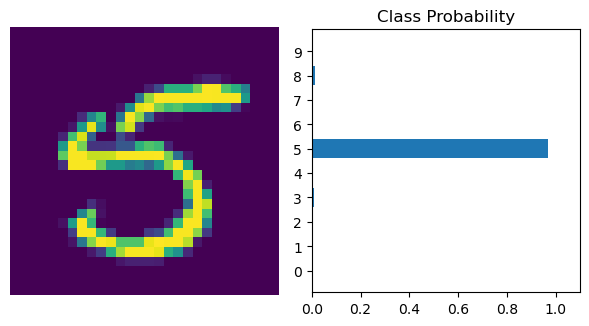

In [23]:
%matplotlib inline
import helper

dataiter = iter(trainloader)
images, labels = next(dataiter)

img = images[0].view(1, 784)
# Turn off gradients to speed up this part
with torch.no_grad():
    logps = model(img)

# Output of the network are log-probabilities, need to take exponential for probabilities
ps = torch.exp(logps)
helper.view_classify(img.view(1, 28, 28), ps)

Agora nossa rede é (quase) brilhante (treinamos e “testamos” nos mesmos dados). Ele pode prever com precisão os dígitos em nossas imagens. A seguir, você escreverá o código para treinar uma rede neural em um conjunto de dados mais complexo.